In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from clib.geolocation_1D import *

# 2 sources

Text(0.5,0,'x [km]')

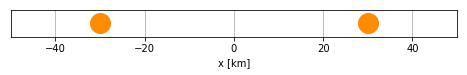

In [2]:
### create an ensemble of sources
dx=60. *1.e3 # in meters
sources=[]
sources.append(source( dx*.5, 0))
sources.append(source(-dx*.5, 0))
Ns2 = len(sources)

### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources]
plt.ylim([-3, 3])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x [km]')

#plt.savefig('geoloc1D', dpi=100)

# 3 sources

Text(0.5,0,'x [km]')

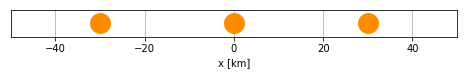

In [3]:
### create an ensemble of sources
dx=60. *1.e3 # in meters
sources3=[]
sources3.append(source( dx*.5, 0))
sources3.append(source( dx*0., 0))
sources3.append(source(-dx*.5, 0))
Ns3 = len(sources)


### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources3]
plt.ylim([-3, 3])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x [km]')

#plt.savefig('geoloc1D', dpi=100)

# 4 sources

Text(0.5,0,'x [km]')

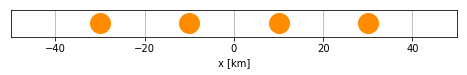

In [4]:
### create an ensemble of sources
dx=60. *1.e3 # in meters
sources4=[]
sources4.append(source(-dx*.5, 0))
sources4.append(source(-dx/6, 0))
sources4.append(source( dx/6, 0))
sources4.append(source( dx*.5, 0))

Ns4 = len(sources)


### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources4]
plt.ylim([-3, 3])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x [km]')

#plt.savefig('geoloc1D', dpi=100)

# 5 sources

Text(0.5,0,'x [km]')

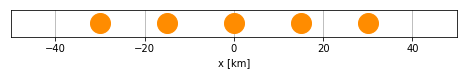

In [5]:
### create an ensemble of sources
dx=60. *1.e3 # in meters
sources5=[]
sources5.append(source(-dx*.5, 0))
sources5.append(source(-dx/4, 0))
sources5.append(source(-dx*0., 0))
sources5.append(source( dx/4, 0))
sources5.append(source( dx*.5, 0))

Ns5 = len(sources)


### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources5]
plt.ylim([-3, 3])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x [km]')

#plt.savefig('geoloc1D', dpi=100)

# 6 sources

Text(0.5,0,'x [km]')

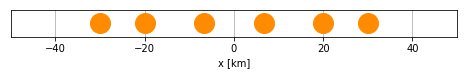

In [6]:
### create an ensemble of sources
dx=60. *1.e3 # in meters
sources6=[]
sources6.append(source(-dx*.5, 0))
sources6.append(source(-dx/3, 0))
sources6.append(source(-dx/9., 0))
sources6.append(source( dx/9., 0))
sources6.append(source( dx/3, 0))
sources6.append(source( dx*.5, 0))

Ns6 = len(sources)


### plot
plt.figure(figsize=(8,1.5))
ax=plt.subplot(111)
[s.plot() for s in sources6]
plt.ylim([-3, 3])
plt.xlim([-50,50])
ax.grid()
ax.set_aspect('equal')
ax.get_yaxis().set_visible(False)
plt.xlabel('x [km]')

#plt.savefig('geoloc1D', dpi=100)

---
---
---
# Fonctions de Calculs

In [7]:
def simu (r, sources, Nmc, var, t_drift) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=t_drift)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, \
                                                                         clock_drift=t_drift, \
                                                                         x0=[x[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    bias_y = y[np.where(su==1)].mean()-r.y
    #print('x[np.where(su==1)].mean() :' , x[np.where(su==1)].mean())
    #print('r.x : ', r.x)
    return (d_rms, bias_x, su)



In [8]:
from ipywidgets import FloatProgress
from IPython.display import display


def transect (sources, X, Y, Nmc, var, clock_drift = False, e_dt=0.01) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    
    r = receiver(X[0], Y, e_dt=e_dt)
    r_dt = r.dt
    
    f = FloatProgress(value = 0., min=0., max=100., step=1., orientation='horizontal', description = 'Loading :')
    display(f)
    
    for i in range (len(X)) :
        
        f.value = i/len(X)*100.

        # init a receiver
        r = receiver(X[i], Y, e_dt=e_dt)
        #r.dt = r_dt # unchanged variable during simulations 
        #
        d_rms, bias_x, su = simu (r, sources, Nmc, var = var, t_drift = clock_drift)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        Success_t[:,i] = su

    f.value = 100.
    
    return RMS_t, BiasX_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('mean (rms) = %.1fm  /// max (rms) = %.1f m' % (np.mean(RMS_t), np.max(RMS_t)))
    print('mean (bias) = %.1fm /// max (bias) = %.1f m' % (np.mean(Biais_t), np.max(Biais_t)))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error' )
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias on x ' )
    
    plt.show()
    

---
---
# Calculs des RMS sur transect

In [9]:
### init a receiver
r=receiver(-35. *1.e3, 0, e_x=10.e3, e_dt=0.)
### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=None, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [10]:
L = 120.* 1.e3
X = np.linspace(-L/2.,L/2.,121)  # resolution : 1km
Y = 0. 

In [11]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t2, BiasX_t2, Success_t2 = transect (sources, X, Y, Nmc, var, \
                                      clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

In [12]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t3, BiasX_t3, Success_t3 = transect (sources3, X, Y, Nmc, var, \
                                      clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

In [13]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t4, BiasX_t4, Success_t4 = transect (sources4, X, Y, Nmc, var, \
                                      clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

In [14]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t5, BiasX_t5, Success_t5 = transect (sources5, X, Y, Nmc, var, \
                                      clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

In [15]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t6, BiasX_t6, Success_t6 = transect (sources6, X, Y, Nmc, var, \
                                      clock_drift = False)

FloatProgress(value=0.0, description='Loading :')

In [19]:
### Sans dérive
print('RMS 2 sources : ', np.mean(RMS_t2))
print('RMS 3 sources : ', np.mean(RMS_t3[1:]))
print('RMS 4 sources : ', np.mean(RMS_t4))
print('RMS 5 sources : ', np.mean(RMS_t5))
print('RMS 6 sources : ', np.mean(RMS_t6))

RMS 2 sources :  1.0650204153021288
RMS 3 sources :  0.8570431917614935
RMS 4 sources :  0.745515398324802
RMS 5 sources :  0.6724691073830956
RMS 6 sources :  0.6077021221758122


In [80]:
### Sans dérive
print('RMS 2 sources : ', np.mean(RMS_t2))
print('RMS 3 sources : ', np.mean(RMS_t3))
print('RMS 4 sources : ', np.mean(RMS_t4))
print('RMS 5 sources : ', np.mean(RMS_t5))
print('RMS 6 sources : ', np.mean(RMS_t6))


RMS 2 sources :  1.0518980063851389
RMS 3 sources :  0.8613114000333876
RMS 4 sources :  0.7497301724961143
RMS 5 sources :  0.669007678726451
RMS 6 sources :  0.6076429080027064


In [20]:
xx = np.array([2., 3., 4., 5.,6.])
XX = 1/np.sqrt(xx)
YY = np.array([np.mean(RMS_t2), np.mean(RMS_t3[1:]), \
               np.mean(RMS_t4), np.mean(RMS_t5), np.mean(RMS_t6)])

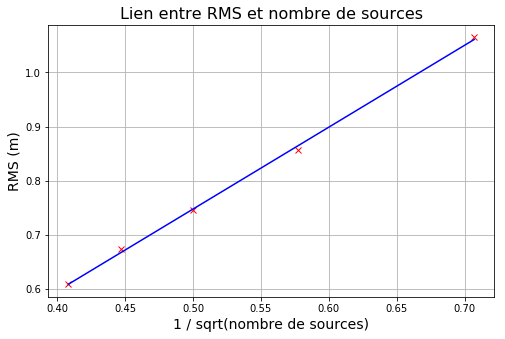

In [21]:
plt.figure(figsize=(8,5))
plt.plot(XX,YY,'rx')
res = np.polyfit(XX,YY,1)
plt.plot(XX,res[0]*XX+res[1],'b')
plt.xlabel('1 / sqrt(nombre de sources)', fontsize=14)
plt.ylabel('RMS (m)', fontsize=14)
plt.title ('Lien entre RMS et nombre de sources', fontsize=16)
plt.grid()

plt.savefig('nbre_sources', dpi=100)

---
---
# Avec dérive

In [91]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_d2, BiasX_d2, Success_d2 = transect (sources, X, Y, Nmc, var, \
                                      clock_drift = True, e_dt=0.026)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

In [92]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_d3, BiasX_d3, Success_d3 = transect (sources3, X, Y, Nmc, var, \
                                      clock_drift = True, e_dt=0.026)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations


In [93]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_d4, BiasX_d4, Success_d4 = transect (sources4, X, Y, Nmc, var, \
                                      clock_drift = True, e_dt=0.026)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations


In [94]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_d5, BiasX_d5, Success_d5 = transect (sources5, X, Y, Nmc, var, \
                                      clock_drift = True, e_dt=0.026)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

In [95]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_d6, BiasX_d6, Success_d6 = transect (sources6, X, Y, Nmc, var, \
                                      clock_drift = True, e_dt=0.026)

FloatProgress(value=0.0, description='Loading :')

No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more iterations
No convergence, try with 1000 more

In [99]:
#### avec dérive à 26ms
print('RMS 2 sources : ', np.mean(RMS_d2))
print('RMS 3 sources : ', np.mean(RMS_d3))
print('RMS 4 sources : ', np.mean(RMS_d4))
print('RMS 5 sources : ', np.mean(RMS_d5))
print('RMS 5 sources : ', np.mean(RMS_d6))

RMS 2 sources :  18.258261138681178
RMS 3 sources :  15.497188193853255
RMS 4 sources :  14.05844214591267
RMS 5 sources :  15.238370787825758
RMS 5 sources :  13.625463425562781


In [101]:
#### avec dérive à 26ms
print('RMS 2 sources : ', np.mean(RMS_d2[35:85]))
print('RMS 3 sources : ', np.mean(RMS_d3[35:85]))
print('RMS 4 sources : ', np.mean(RMS_d4[35:85]))
print('RMS 5 sources : ', np.mean(RMS_d5[35:85]))
print('RMS 5 sources : ', np.mean(RMS_d6[35:85]))

RMS 2 sources :  1.0675144840959228
RMS 3 sources :  0.9223731156510548
RMS 4 sources :  0.8276676877211134
RMS 5 sources :  0.7420412216712161
RMS 5 sources :  0.6725675859904768


In [104]:
xx = np.array([2., 3., 4., 5.,6.])
XX = 1/np.sqrt(xx)
YY = np.array([np.mean(RMS_d2[35:85]), np.mean(RMS_d3[35:85]), \
               np.mean(RMS_d4[35:85]), np.mean(RMS_d5[35:85]), np.mean(RMS_d6[35:85])])

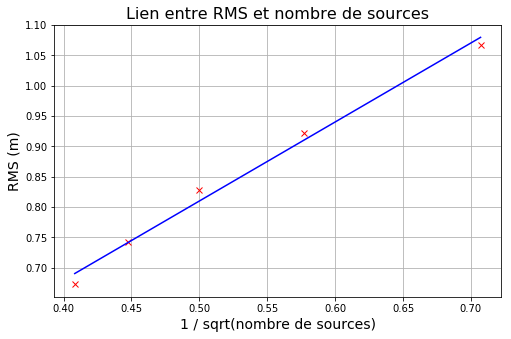

In [105]:
plt.figure(figsize=(8,5))
plt.plot(XX,YY,'rx')
res = np.polyfit(XX,YY,1)
plt.plot(XX,res[0]*XX+res[1],'b')
plt.xlabel('1 / sqrt(nombre de sources)', fontsize=14)
plt.ylabel('RMS (m)', fontsize=14)
plt.title ('Lien entre RMS et nombre de sources', fontsize=16)
plt.grid()